# 前準備

## import

In [3]:
# 必要なライブラリーのインストール
import numpy as np
import pandas as pd

# 可視化
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
sns.set_style('whitegrid')

# 正規化のためのクラス
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

## データ取得用

import urllib

,Japanese,Math,English
Student,,,
0,80,85,100
1,96,100,100
2,54,83,98
3,80,98,98
4,90,92,91


(37, 3)


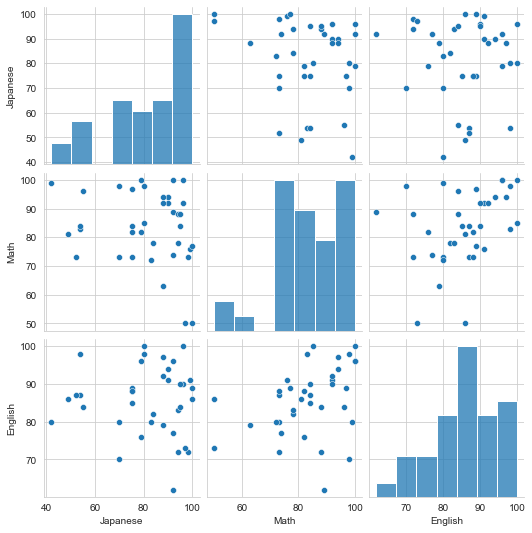

In [4]:
# ウェブ上のリソースを指定する
url = 'https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/SchoolScore.txt'
# 指定したURLからリソースをダウンロードし、名前をつける。
urllib.request.urlretrieve(url, 'SchoolScore.txt')

df = pd.read_csv("SchoolScore.txt", sep='\t', na_values=".", index_col=["Student"]) # データの読み込み

# 確認
display(df.head(5))
print(df.shape)

pg = sns.pairplot(df)

# 分割型クラスタリングを実装
下記論文の手法を実装
- Macnaughton Smith, P., Williams, W., Dale, M. and Mockett, L. (1965). Dissimilarity analysis: anew technique of hierarchical subdivision, Nature 202:1034-1035.

In [6]:
class MacnaughtonClustering:
    # 初期化関数
    def __init__(self, df):
        self.df = df
        
        # クラス内で必要なlibraryのimport
        import numpy as np
        
    # 距離行列を作成する関数
    def makeDistanceMatrix(self):
        # 各データの組み合わせを作成
        combination_df = self.df-self.df[:, np.newaxis]
        
        # 組み合わせごとに距離を計算
        d_matrix = np.array([[np.linalg.norm(combination_df[i, j]) for i in range(0, len(self.df))] for j in range(0, len(self.df))])
        
        # 出力
        self.d_matrix = d_matrix 
        return(d_matrix)
    
    # クラスタ分割を制御・実行する関数
    def doClustering(self):
        
        # クラスタを分割する関数
        def doClusteringCore(target):
            G1 = target.copy() # 移動元
            G2 = [] # 移動先

            # 移動すべき1個目の点を決める
            tmp_d_matrix = self.d_matrix[np.ix_(G1, G1)]
            maxi = np.argmax(
                np.apply_along_axis(
                    np.mean,
                    axis = 0,
                    arr = tmp_d_matrix)
            )
            
            # cluster1のmiをcluster2に移動するメソッド
            def move(cluster1, cluster2, mi):
                trans_data = cluster1[mi]
                cluster1.remove(trans_data)
                cluster2.append(trans_data)

            # 点の移動
            move(cluster1 = G1, cluster2 = G2, mi = maxi)
    
            while True:
                # 2個目以降の移動すべき点を決める
                ## G1の各点の他の点との平均距離
                tmp_d_matrix = self.d_matrix[np.ix_(G1, G1)]
                G1_mean = np.apply_along_axis(
                    sum,
                    axis = 0,
                    arr = tmp_d_matrix
                )/(len(G1)-1)

                ## G1の各点とG2の各点の平均距離
                tmp_d_matrix = self.d_matrix[np.ix_(G1, G2)]
                d_g1tog2 = np.apply_along_axis(
                    np.mean,
                    axis = 1,
                    arr = tmp_d_matrix
                )

                ## 「G1の各点の他の点との平均距離」-「G1の各点とG2の各点の平均距離」
                criterion = G1_mean-d_g1tog2

                ## 判定条件の作成
                cond = (criterion <= 0)
                tf = all(cond)
                
                # 判定がTrueの場合、while文から抜け出し、分割終了
                # 判定がFalseの場合、点を移動させ分割続行
                if tf:
                    break
                else:
                    maxi = np.argmax(criterion)
                    move(cluster1 = G1, cluster2 = G2, mi = maxi)
                    
            cluster_diff = np.sum(self.d_matrix[np.ix_(G1, G2)])/(len(G1)*len(G2))
            
            # 出力
            return([G1, G2, cluster_diff])
        
        # クラスタリング結果を格納するDataFrame定義
        tmp0_result_DF = pd.DataFrame(columns=["tmp_cluster_no", "cluster", "diff", "children"])

        # 0行目は元のクラスタのインデックスを格納
        tmp0_result_DF.loc[0] = [0, list(range(0, len(self.df))), np.nan, np.nan]

        # パラメータ設定
        count = 0 # 分割回数
        next_clustering = 0 # 次に分割するクラスタのインデックス
        clustering_done = [] # 既に分割したクラスタ

        # 分割前後の処理を実行する関数
        def clusterSupoort(rdf, nc, cd):
            clustered_1 = max(rdf.index)+1
            clustered_2 = max(rdf.index)+2

            # 分割
            if len(rdf.iloc[nc]["cluster"]) >= 3: # クラスタ数が3以上のとき、通常の分割
                cluster1, cluster2, diff = doClusteringCore(target = rdf.iloc[nc]["cluster"])
            else : # クラスタ数が2のときは、一つずつに分割
                cluster1 = [rdf.iloc[nc]["cluster"][0]]
                cluster2 = [rdf.iloc[nc]["cluster"][1]]
                diff = self.d_matrix[np.ix_(cluster1, cluster2)][0, 0]
                
            rdf.loc[nc] = [nc, rdf.loc[nc]["cluster"], diff, [clustered_1, clustered_2]]
            rdf.loc[clustered_1] = [clustered_1, cluster1, np.nan, np.nan]
            rdf.loc[clustered_2] = [clustered_2, cluster2, np.nan, np.nan]
            cd.append(nc)

        # クラスタに含まれる要素の個数で分割の方法を変える
        while (count < len(self.df)-1):    
            if len(tmp0_result_DF.iloc[next_clustering]["cluster"]) >= 2:
                clusterSupoort(rdf = tmp0_result_DF, nc = next_clustering, cd = clustering_done)
                count += 1
            else:
                clustering_done.append(next_clustering)
        
            next_clustering = min([i for i in tmp0_result_DF.index if i not in clustering_done])
        
        # dendrogramに読み込める形に変更する
        tmp0_result_DF["group_n"] = [len(l) for l in tmp0_result_DF["cluster"]]
        
        ## 要素が2個以上のクラスタに対する処理
        tmp1_result_DF = (
            tmp0_result_DF[tmp0_result_DF["group_n"] >= 2]
            .sort_values("diff", ascending=False)
        )
        cluster_n = len(self.df)
        tmp_cluster_no_list = list(range(cluster_n, 2*cluster_n-1))
        tmp_cluster_no_list.reverse()
        tmp1_result_DF["cluster_no"] = tmp_cluster_no_list
        
        ## 要素が1個のクラスタに対する処理
        tmp2_result_DF = (
            tmp0_result_DF[tmp0_result_DF["group_n"] == 1]
        )
        tmp_cluster_no_list = [l[0] for l in tmp2_result_DF["cluster"]]
        tmp2_result_DF["cluster_no"] = tmp_cluster_no_list
        
        ## 要素が2個以上と1個のクラスタに対するresult_DFをunion
        tmp3_result_DF = (
            tmp1_result_DF
            .append(
                other = tmp2_result_DF,
                ignore_index = True
            )
        )
        
        ## childrenから新規に振ったcluster番号を用いてクラスターを表現
        cluster_list = []
        for c in tmp3_result_DF["children"]:
            if isinstance(c, list):
                tmp_series = tmp3_result_DF.loc[tmp3_result_DF["tmp_cluster_no"] == c[0], "cluster_no"]
                c0 = tmp_series.iloc[-1]
                tmp_series = tmp3_result_DF.loc[tmp3_result_DF["tmp_cluster_no"] == c[1], "cluster_no"]
                c1 = tmp_series.iloc[-1]
                
                cluster_list.append([c0, c1])
            else:
                cluster_list.append(np.isnan)
        
        tmp3_result_DF["cluster_list"] = cluster_list
        
        ## 必要なカラムだけ抜き出し、少し処理
        tmp_linkage_Z = (
            tmp3_result_DF[1<tmp3_result_DF["group_n"]]
            .sort_values("cluster_no", ascending=True)
        )
        
        tmp_Z = []
        for i in tmp_linkage_Z[["cluster_list", "diff", "group_n"]].itertuples():
            i0, i1 = i.cluster_list
            d = i.diff
            n = i.group_n
            tmp_Z.append([i0, i1, d, n])
            
        Z = np.array(tmp_Z)
        
        return(Z)

## テスト用データ作成

In [7]:
# テスト用データ作成
test_data = np.array([
    [1, 1],
    [2, 2],
    [3, 3],
    [4, 4],
    [5, 5],
    [6, 6],
    [7, 7],
    [9, 9]
])

In [9]:
# 動かしてみる
test_class = MacnaughtonClustering(df = test_data)
print(test_class.makeDistanceMatrix())
result = test_class.doClustering()

[[ 0.          1.41421356  2.82842712  4.24264069  5.65685425  7.07106781
   8.48528137 11.3137085 ]
 [ 1.41421356  0.          1.41421356  2.82842712  4.24264069  5.65685425
   7.07106781  9.89949494]
 [ 2.82842712  1.41421356  0.          1.41421356  2.82842712  4.24264069
   5.65685425  8.48528137]
 [ 4.24264069  2.82842712  1.41421356  0.          1.41421356  2.82842712
   4.24264069  7.07106781]
 [ 5.65685425  4.24264069  2.82842712  1.41421356  0.          1.41421356
   2.82842712  5.65685425]
 [ 7.07106781  5.65685425  4.24264069  2.82842712  1.41421356  0.
   1.41421356  4.24264069]
 [ 8.48528137  7.07106781  5.65685425  4.24264069  2.82842712  1.41421356
   0.          2.82842712]
 [11.3137085   9.89949494  8.48528137  7.07106781  5.65685425  4.24264069
   2.82842712  0.        ]]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)
<ipython-input-6-1fe58bd914ad>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2_result_DF["cluster_no"] = tmp_cluster_no_list


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [50.0, 50.0, 65.0, 65.0],
  [57.5, 57.5, 75.0, 75.0],
  [20.0, 20.0, 66.25, 66.25]],
 'dcoord': [[0.0, 1.4142135623730951, 1.4142135623730951, 0.0],
  [0.0, 1.4142135623730951, 1.4142135623730951, 0.0],
  [1.4142135623730951,
   2.8284271247461903,
   2.8284271247461903,
   1.4142135623730951],
  [0.0, 1.4142135623730951, 1.4142135623730951, 0.0],
  [1.4142135623730951, 2.121320343559643, 2.121320343559643, 0.0],
  [2.121320343559643, 4.242640687119285, 4.242640687119285, 0.0],
  [2.8284271247461903,
   6.0104076400856545,
   6.0104076400856545,
   4.242640687119285]],
 'ivl': ['2', '3', '0', '1', '5', '4', '6', '7'],
 'leaves': [2, 3, 0, 1, 5, 4, 6, 7],
 'color_list': ['C1', 'C1', 'C1', 'C2', 'C2', 'C0', 'C0']}

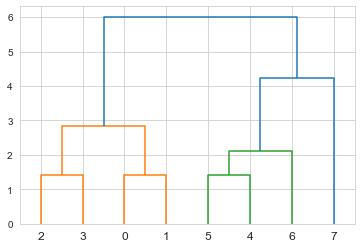

In [10]:
# デンドログラム作成
dendrogram(result)